# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC207 Systems Development for Computational Science


## ac207-autodiff Documentation


**Harvard University**<br/>
**Fall 2021**<br/>
**Project Group #32**: Xuliang Guo.   Van Anh Le.  Hanwen Cui.  Kamran Ahmed.

<hr style="height:2pt">

In [1]:
import requests
from IPython.display import Image, display
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

## Part1. Introduction

Almost all machine learning algorithms can be attributed to solving optimization problems during the training process. If the analytical solution exists, we can achieve the final result by simply substituting numerical calculation. However, not all problems are amenable to analytical solutions. Many times we need to use gradient descent, Newton method, quasi-Newton method, and other numerical optimization algorithms to solve such problems. These algorithms largely rely on the first or second derivative, gradient, Jacobian matrix, Hessian matrix, etc.

- Let's define $f(x)=x^{2} + y^{2} $, and we want its derivative respect to x and y.  ie $\frac{\partial f}{\partial x} $ and $\frac{\partial f}{\partial y} $

For programming to solve the derivative of a function, there are currently 4 methods we can choose:  numerical differentiation, manual differentiation, symbolic differentiation, and what we will introduce -automatic differentiation.

> Automatic Differentiation (AD), also known as computational differentiation, is a method that combines the advantages of symbolic differentiation and numerical differentiation that can efficiently and accurately evaluate derivatives of functions that have been expressed as a computer program.


## Part 2. Background


### Numerical Differentiation


According to the original definition of derivative 

$$ \begin{aligned}
&\frac{\partial f}{\partial x}(a, b)=\lim _{\epsilon \rightarrow 0} \frac{f(a+\epsilon, b)-f(a, b)}{\epsilon} \\
&\frac{\partial f}{\partial y}(a, b)=\lim _{\epsilon \rightarrow 0} \frac{f(a, b+\epsilon)-f(a, b)}{\epsilon}
\end{aligned} $$



we will get an approximate derivative value as long as $\epsilon$ takes a very small value, such as 0.0001. In other words, the numerical method only takes three arguments (objective function, the current value, and the precision(0.0001)) to be able to output an approximate derivative for the current value. However,  the numerical differentiation method is the most computationally expensive among the four methods when there are multiple variables.

From the demo python code below, we can see that the Simple_numerical_diff_x function calls f-function twice.
```python
def Simple_numerical_diff_x(f,x,y x_eps):
    return (f(x + x_eps,y) - f(x,y)) / (x_eps)
```
For the one variable scenario above, the Simple_numerical_diff calls f() twice. For an equation with n variables, to compute the gradient of all dimensions, f() will be called at least n+1 times. When dealing with a large neural network, such operations will greatly reduce our efficiency.

To make matters worse, the roundoff error and truncation error caused by the numerical approximation makes it even less suitable for practical application scenarios. Even if we make $\epsilon$ equal to 1e-10, the roundoff error will still exist, but the calculations will slow down even more due to the sharp increase of digits. For the truncation error, it can be reduced not be eliminated by the the following center difference approximation: $f^{\prime}(x)=\lim _{\epsilon \rightarrow 0} \frac{f(x+\epsilon ,y)-f(x-\epsilon ,y)}{2 \epsilon }$. Although the numerical differentiation can not give a precise result, it is often used to check the results of other methods within a given accuracy.


### Manual Differentiation

Another method is we grab a pen and a piece of paper, manually write down the derivate formula based on our calculus knowledge and then write it into python code.

$$ \frac{\partial f(x,y)}{\partial x}=\frac{\partial\left(x^{2}+y^{2}\right )}{\partial x} =2x$$

However, within the manual method, every time we modify the objective function, the stored derivative expression need also be re-write. The method may become very wordy and time-costly when it is applied to more complex functions. So the manual differentiation obviously cannot be applied to automated machine learning algorithms due to the requirements of human intervention.


### Symbolic Differentiation

Symbolic differentiation is a method used to replace the above manual differentiation, using algebraic programming to implement the automatic derivative of some combined functions, such as:

$$\begin{gathered}
\frac{d}{d x}(f(x)+g(x))=\frac{d}{d x} f(x)+\frac{d}{d x} g(x) \\
\frac{d}{d x} f(x) g(x)=\left(\frac{d}{d x} f(x)\right) g(x)+f(x)\left(\frac{d}{d x} g(x)\right) \\
\end{gathered}$$

Symbolic differentiation first expands the objective function to a tree diagram and then calculates and stores the partial derivative of all leaf nodes and stores them in memory. Treat all the stored expression as a new element, the symbolic differentiation iteratively compute the composite derivative of the parents node. After several upward iterations, we will finally obtain the symbolic expression of composited elements and it is easy to obtain the final answer by simply substituting the initial value.

A significant problem with this method is "expression swell". For a complex objective function, the symbolic method will produce a huge calculation graph, which can't be simplified and will lead to an extremely slow calculation through the entire expression trees.

> - Numerical differentiation emphasizes the direct substitution of finite numerical approximation at the beginning; 
> - Symbolic differentiation emphasizes generating an algebraic derivative expression and then substituting the value at the final step;


### Automatic Differentiation

> - Automatic differentiation will apply the symbolic differentiation method to the most basic operators, such as constants, power functions, exponential functions, logarithmic functions, trigonometric functions, etc., Then substitutes the initial value and applies rules of composition derivative, we achieve the final answer of a wide class of functions automatically and precisely. Due to the basic of only applying symbolic differentiation law to basic functions, it can flexibly combine the loop structure and conditional structure of the programming language without worrying about the problem of expression swell.

### AD Forward Mode and Dual numbers
AD computes the derivative of a complex function $f(x,y)$ by breaking it down into a series of intermediate elementary operations. The chain rule allows us to use the derivative of these intermediate functions to compute $\frac{\partial f}{\partial x}$. In the forward mode AD, we work from the inside out, i.e starting with the value of $x$ at which we want to evaluate and ending with the function $f(x,y)$. 

The evaluation trace table and computational graph below demonstrate this process:
* We'll use the function defined in the introduction, $f(x)=x^{2} + y^{2}$, and evaluate $\frac{\partial f}{\partial x} $ and $\frac{\partial f}{\partial y} $ at $(x,y) = (1,1)$.
* The first two traces $x_{0}$ and $x_{1}$ are the starting values $(x,y) = (1,1)$. 
* For each subsequent trace, elementary operations are applied to the previous traces, until we reach the final function in the last trace. The elementary operations applied are represented on the arrows in the computational graph.
* At each trace, both the derivative ($\nabla_{x}$, $\nabla_{y}$) and value of the intermediate operations are computed. We arrived at the derivatives $(\nabla_{x}$, $\nabla_{y}) = (2,2)$ in the last trace.

#####  Evaluation Trace Table
\begin{align}
 f(x,y)=x^{2} + y^{2} 
\end{align}


| trace   | elem op.    | value | elem der.           | $\nabla_{x}$| $\nabla_{y}$ |
| :---:   | :------:    | :---: | :-------:           | :---------: | :----------: |
| $x_{0}$ | $$x$$       | $$1$$ | $$\dot{x}$$ | $$1$$         | $$0$$          |
| $x_{1}$ | $y$         | $1$   | $\dot{y}$   | $0$           | $1$          |
| $v_{1}$ | $x_{1}^{2}$ | $1$   | $2x_{1}\dot{x_{1}}$ | $0 $         | $2$          |
| $v_{2}$ | $x_{0}^{2}$ | $1$   | $2x_{0}\dot{x_{0}}$ | $2$          | $0$          |
| $f$ | $v_{2} + v_{3}$ | $2$   | $\dot{v_1}+\dot{v_2}$ | $2$         | $2$          |

##### Computational Graph - Forward Mode

As we saw from the trace table, both the derivative and value of the intermediate operations are computed at each trace. Dual numbers can be used as a data structure to store and carried these values forward, where each value and derivative pair can be stored as the real part and the dual part of a dual number respectively. The addition and multiplication properties of dual numbers, as well as the fact that its derivative can be computed using the Taylor series, make it a useful data structure for forward mode AD.

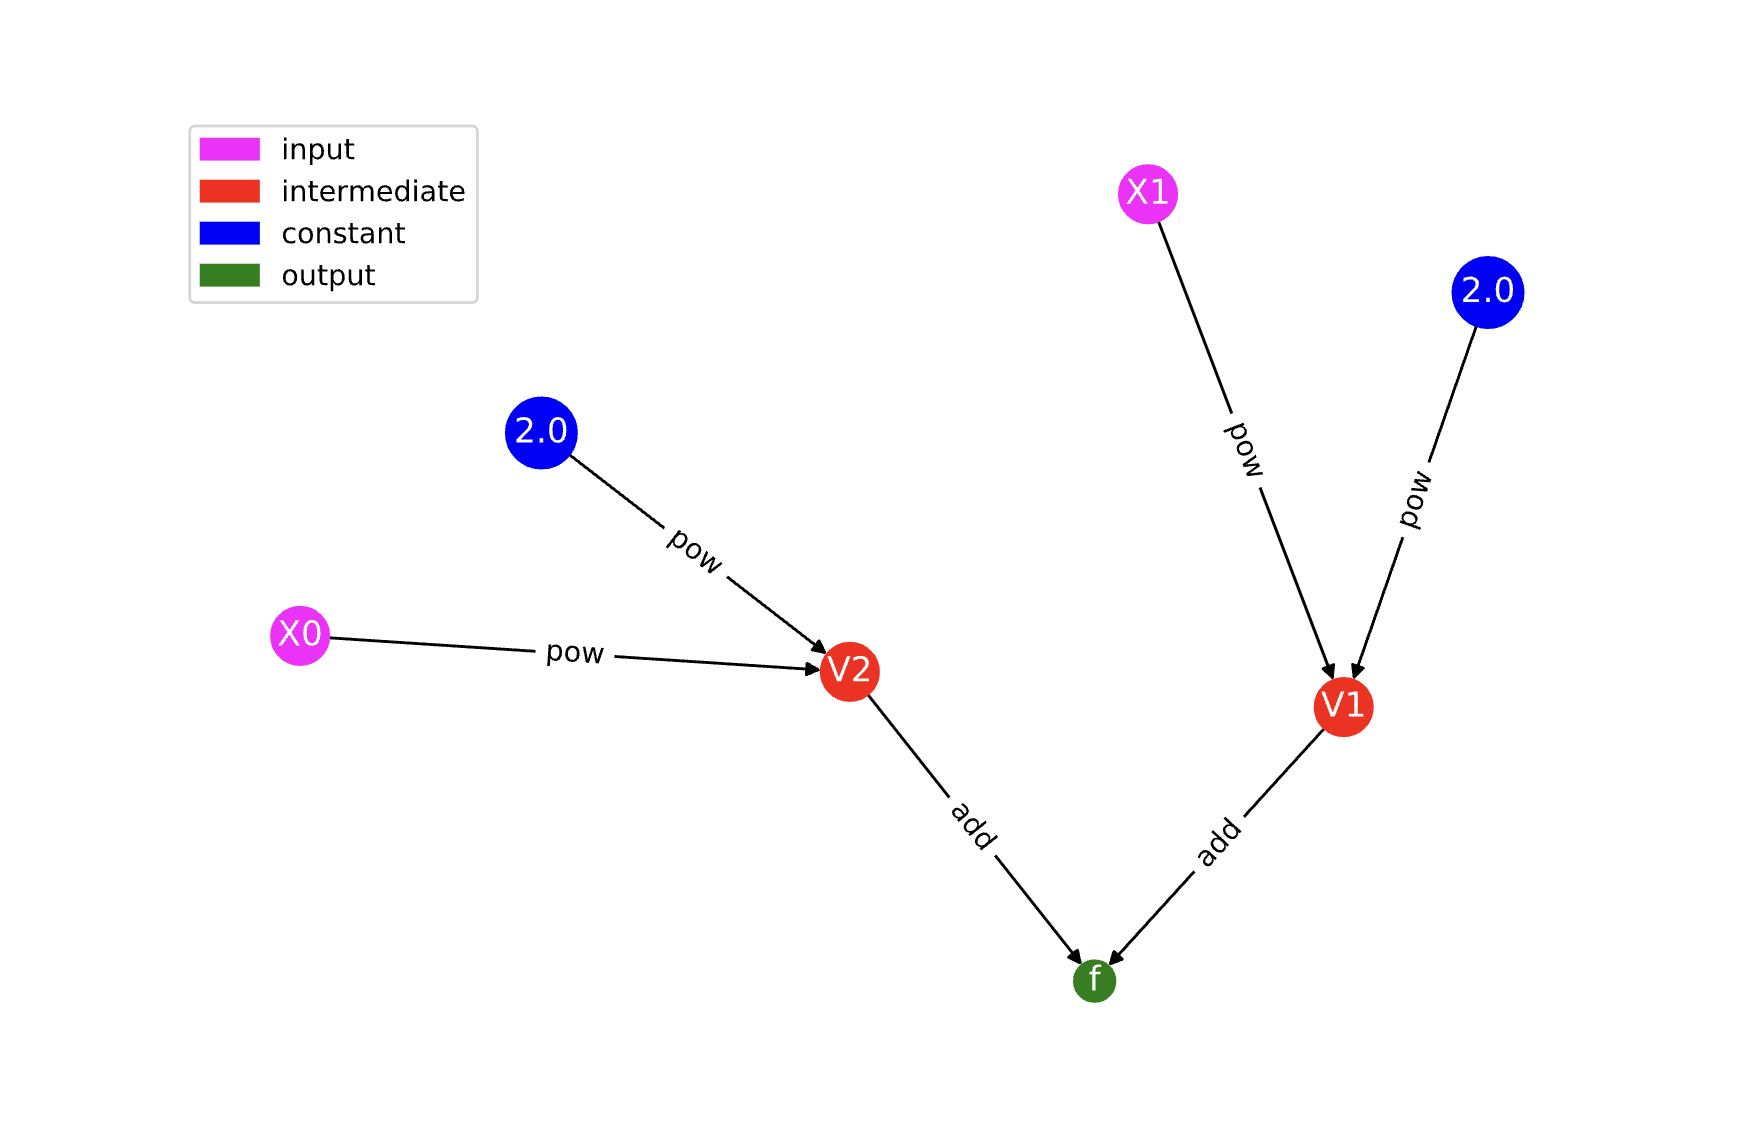

In [2]:
display(Image(filename="graph1_forward.png"))

### AD Reverse Mode
In reverse mode AD, instead of working from the inside out, we apply the chain rule backwards. To do this, we first need to perform a forward pass where the partial derivative of intermediate variables with respect to its parent are computed. We then performed a reverse pass and apply the chain rule starting from the last intermediate variable using the computed partial derivative. 

##### Computational Graph - Reverse Mode


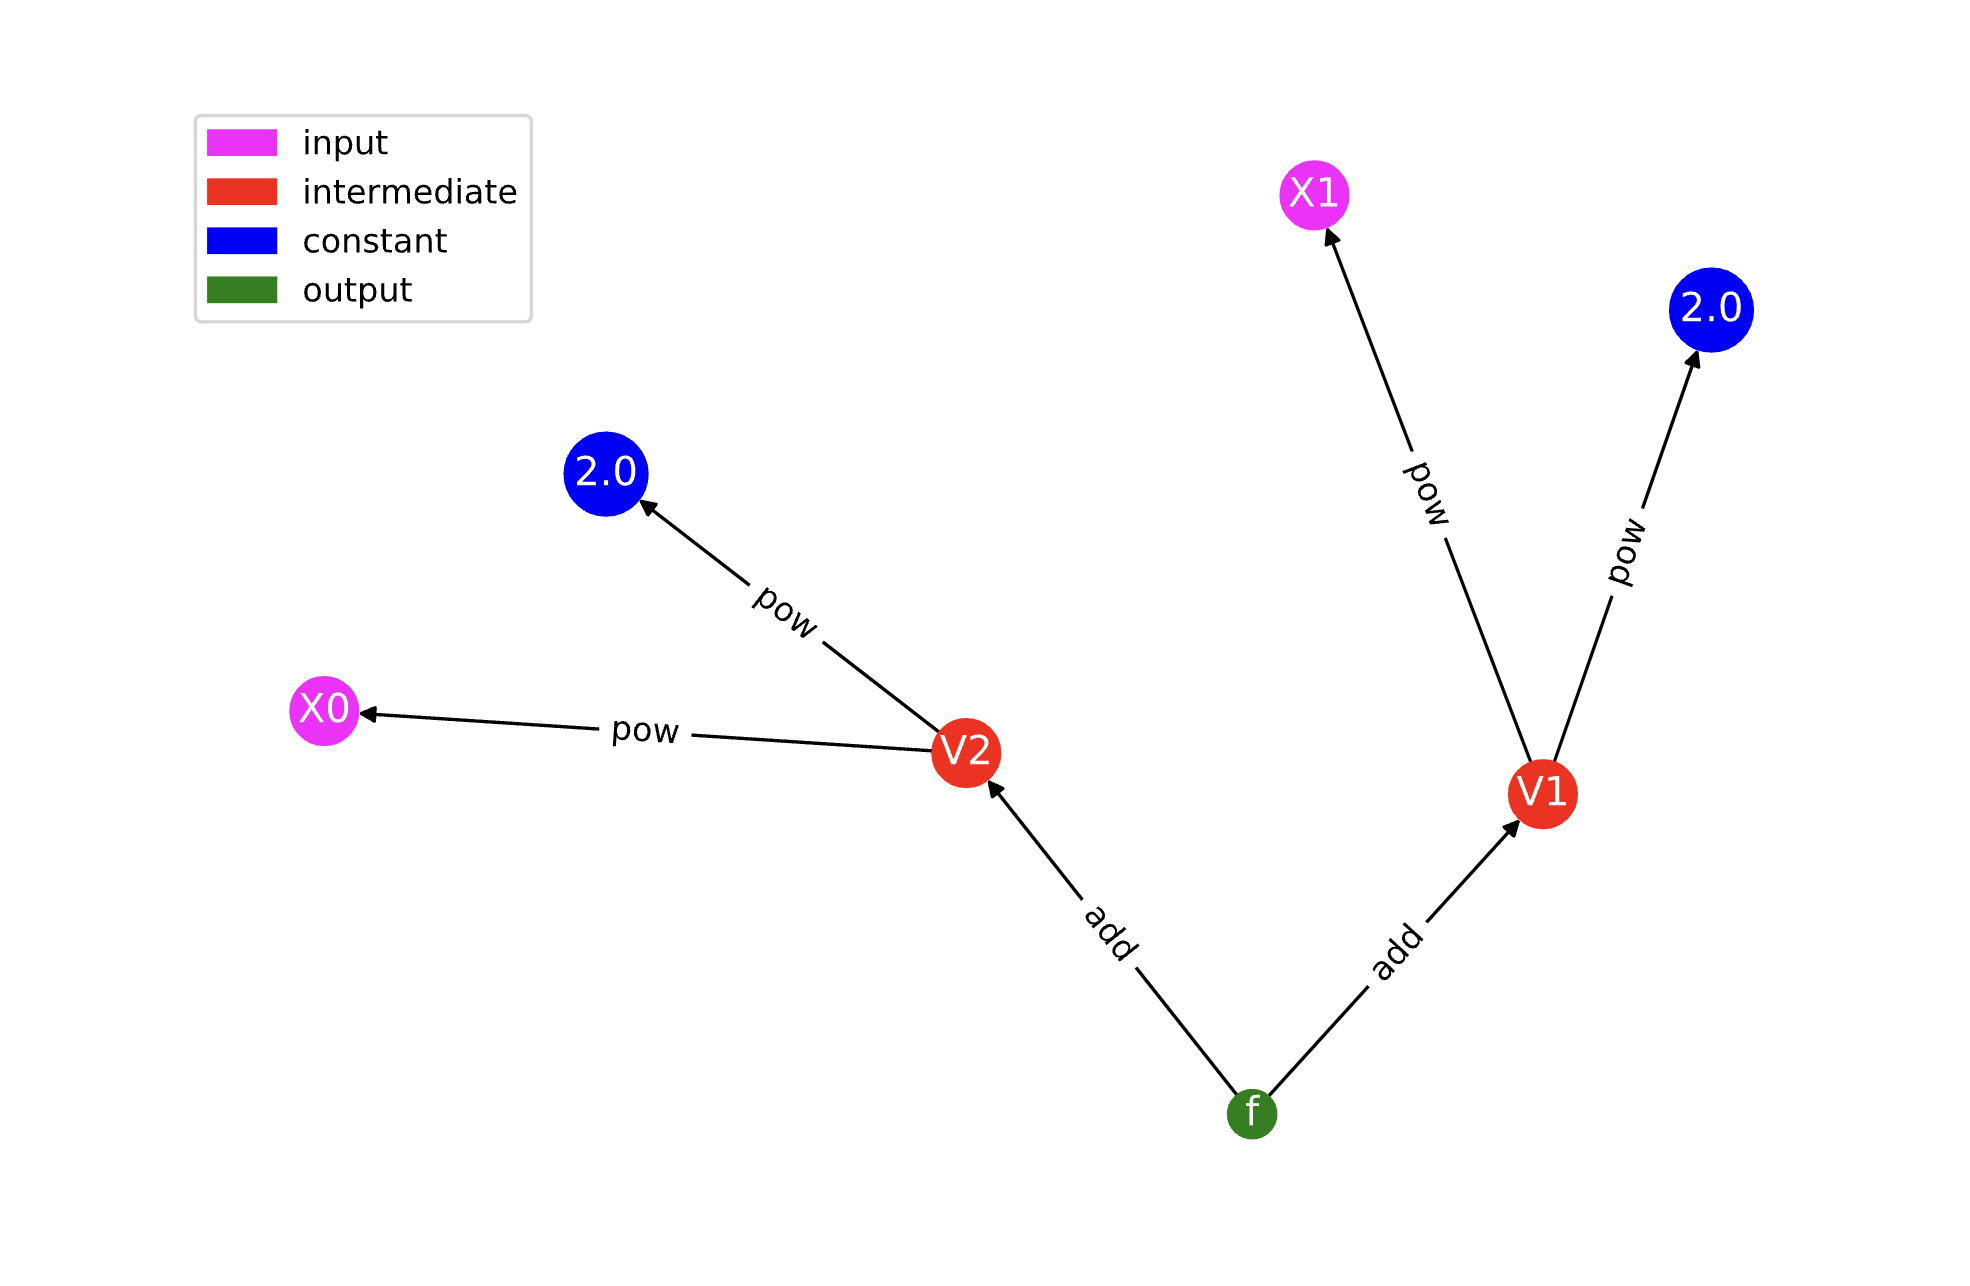

In [3]:
display(Image(filename="graph2_reverse.png"))

<a id='how-to-use'></a>
## Part 3. How to Use autodiff
Our package can be installed from GitHub or PyPI.

**How to install**

```
$ git clone https://github.com/cs107-XKVH/cs107-FinalProject.git
$ cd cs107-FinalProject
$ python3 -m venv autodiff-env
$ source autodiff-env/bin/activate
$ pip install .
```

via PyPI (note that our package name is `ac207-autodiff` but you can import it as `autodiff` after installation)
```
$ python3 -m venv autodiff-env
$ source autodiff-env/bin/activate
$ pip install ac207-autodiff
```

Interact with our package by instantiating core data stuctures depending on which AD mode you would like to use. Specifically, the `ad.Dual` class is used for forward mode AD, while `ad.reverse.Node` is used for reverse mode AD. In either mode, you can construct user-defined functions using our data structures and overloaded elementary operations. 

Our automatic differentiation package’s default behavior uses forward mode.

You can import this as follows:
```python3
>>> import autodiff as ad
```

If you would like to use reverse mode, please explicitly import it as:
```python3
>>> import autodiff.reverse as ad
```

Examples on how to interact with our package can be found below and detailed documentation can be found [here](https://cs107-xkvh.github.io).


### Forward Mode

Our automatic differentiation package’s default behavior uses forward mode which evaluates the function at the specified values and automatically computes the gradient(s).

In [4]:
import autodiff as ad

# instantiate Dual object with value 2 (derivative defaults to 1)
x = ad.Dual(2)

# define and evaluate univariate function
f = 7 * (x ** 3) + 3 * x

print(f"Function value: {f.val}, derivative: {f.der}")

Function value: 62, derivative: [87.]


**Multivariate functions** 

We provide flexible options to support this.

*Option 1*: create multiple Dual numbers via `Dual.from_array`, which constructs proper seed vectors for each variable. i.e. Dual numbers will have value of `X[i]` and zero derivative vector where the `i-th` element has a value of 1.

In [5]:
import autodiff as ad

# helper static method
x, y = ad.Dual.from_array([2, 4])

f = 7 * (x ** 3) + 3 * y

print(f"Function value: {f.val}, derivative: {f.der}")

Function value: 68, derivative: [84.  3.]


*Option 2*: user defines seed.

In [6]:
import autodiff as ad

x = ad.Dual(2, der=[1, 0])
y = ad.Dual(4, der=[0, 1])
f = 7 * (x ** 3) + 3 * y

print(f"Function value: {f.val}, derivative: {f.der}")

Function value: 68, derivative: [84.  3.]


**Vector functions**

We support vector functions with multiple inputs.

In [7]:
import autodiff as ad

x, y, z = ad.Dual.from_array([2, 4, 6])

def f(x, y, z):
    """
    Vector function mapping 3 inputs to 2 outputs

    Parameters
    ----------
    x, y, z : Dual

    Returns
    -------
    Tuple of Dual objects
    """
    f1 = 7 * (x ** 3) + 3 * y
    f2 = y / x + z ** 2
    return (f1, f2)

f1, f2 = f(x, y, z)

print(f"First function value: {f1.val}, derivative: {f1.der}")
print(f"Second function value: {f2.val}, derivative: {f2.der}")

First function value: 68, derivative: [84.  3.  0.]
Second function value: 38.0, derivative: [-1.   0.5 12. ]


Note that in the example above, `f1` does not include `z` as an input. This results in `f1` being a function of only `x` and `y`, but it's derivative vector (`f1.der`) will be three-dimensional. This is because when constructing our `Dual` numbers we assume that the user will use all variables in their functions. The gradient with respect to `x` and `y` are correct, but the gradient with respect to `z` will be 0.

**Elementary operations**

We will allow users to import overloaded elementary functions (sine, cosine, tangent, exponential, log, sqrt) to perform operations on Dual numbers.

In [8]:
import autodiff as ad

x = ad.Dual(1)
f = ad.cos(x) + ad.exp(x**2)

print(f"Function value: {f.val:.4f}, derivative: {f.der[0]:.4f}")

Function value: 3.2586, derivative: 4.5951


In [9]:
import autodiff as ad

x, y = ad.Dual.from_array([2, 4])

# multivariate function
f = ad.exp(x) + y

print(f"Function value: {f.val:.4f}, derivative: [{f.der[0]:.4f} {f.der[1]:.4}]")

Function value: 11.3891, derivative: [7.3891 1.0]


### Reverse Mode

As mentioned above, our automatic differentiation package’s default behavior uses forward mode which evaluates the function at the specified values and automatically computes the gradient(s). 

The `Node` data structure and associated elementary operations are contained within the `autodiff.reverse` module.

You will have to explicitly import it as:
```python
>>> import autodiff.reverse as ad
```

Reverse mode only evalates the function at the specified values. To calculate the gradient with respect to each input, you have to explicitly call `Node.grad()`. Examples can be found below.

In [10]:
import autodiff.reverse as ad

"""
Function with a single argument. The derivative of the function is not
stored within the function object, but rather is computed on the fly
when `x.grad()` is called.
"""

# instantiate Node object with value 2
x = ad.Node(2)

# define and evaluate univariate function
f = 7 * (x ** 3) + 3 * x

# compute gradient
grad = x.grad()

print(f"Function value: {f.val}, derivative w.r.t x = {grad}")

Function value: 62, derivative w.r.t x = 87.0


Note that to reuse the `x` variable again, without accumulating gradients you must call `ad.Node.zero_grad(x)`. A more detailed example can be found below when using vector functions.

**Multivariate functions**

Much like forward mode AD, we provide flexible options to support this in reverse mode.

Option 1: create multiple Nodes via Node.from_array.

In [11]:
import autodiff.reverse as ad

# helper static method
x, y = ad.Node.from_array([2, 4])

# multivariate function
f = 7 * (x ** 3) + 3 * y

# explicitly compute all gradients w.r.t. x and y
grad = [x.grad(), y.grad()]

print(f"Function value: {f.val}, derivative: {grad}")

Function value: 68, derivative: [84.0, 3.0]


Option 2: create individual Node objects.

In [12]:
import autodiff.reverse as ad

x = ad.Node(2)
y = ad.Node(4)

# multivariate function
f = 7 * (x ** 3) + 3 * y

# explicitly compute all gradients w.r.t. x and y
grad = [x.grad(), y.grad()]

print(f"Function value: {f.val}, derivative: {grad}")

Function value: 68, derivative: [84.0, 3.0]


**Vector functions**

We support vector functions with multiple inputs.

In [13]:
import autodiff.reverse as ad

x, y, z = ad.Node.from_array([2, 4, 6])

def f(x, y, z):
    """
    Vector function mapping 3 inputs to 2 outputs

    Parameters
    ----------
    x, y, z : Node

    Returns
    -------
    Tuple of Node objects and their gradients

    Note
    ----
    ``ad.Node.zero_grad()`` must be called before constructing
    a second function object with the same inputs.
    """
    f1 = 7 * (x ** 3) + 3 * y

    # compute gradient w.r.t. all inputs, before computing f2
    f1_grad = [x.grad(), y.grad(), z.grad()]

    # must be called before computing f2, otherwise gradients will accumulate
    ad.Node.zero_grad(x, y, z) 

    f2 = y / x + z ** 2
    f2_grad = [x.grad(), y.grad(), z.grad()]

    return f1, f1_grad, f2, f2_grad

f1, f1_grad, f2, f2_grad = f(x, y, z)

print(f"First function value: {f1.val}, derivative: {f1_grad}")
print(f"Second function value: {f2.val}, derivative: {f2_grad}")

First function value: 68, derivative: [84.0, 3.0, 1.0]
Second function value: 38.0, derivative: [-1.0, 0.5, 12.0]


Note again that in the example above, `f1` does not include `z` as an input. This results in `f1` being a function of only `x` and `y`. We needlessly call `z.grad()` to demonstrate that this behavior is different from that of our forward mode implementation. In the forward mode example implementation of this function, the gradient with respect to `z` was 0. Here, since `z` is not an input to `f1`, the partial derivative with respect to itself is 1.0. 

Ultimately, just note that this behavior is different and don't unnecessarily call `Node.grad()` if that node is not an input to your function.

**Elementary operations**

We will allow users to import overloaded elementary functions (sine, cosine, tangent, exponential, log, sqrt) to perform operations on Nodes.

In [14]:
import autodiff.reverse as ad

x = ad.Node(1)
f = ad.cos(x) + ad.exp(x**2)

grad = x.grad()

print(f"Function value: {f.val:.4f}, derivative: {grad:.4f}")

Function value: 3.2586, derivative: 4.5951


In [15]:
import autodiff.reverse as ad

x, y = ad.Node.from_array([2, 4])

# multivariate function
f = ad.exp(x) + y

grad = [x.grad(), y.grad()]
print(f"Function value: {f.val:.4f}, derivative: [{grad[0]:.4f} {grad[1]:.4}]")

Function value: 11.3891, derivative: [7.3891 1.0]


## Part 4. Software Organization

**Project structure**

```zsh
cs107-FinalProject
├── docs
│   ├── documentation.ipynb # docs, usage and tutorials
│   └── milestone1.ipynb
│   └── milestone2_progress.ipynb
│   └── milestone2.ipynb
├── src # main src directory where we import necessary objects and functions from `src`
│   └── autodiff
│       ├── forward # forward mode module
│       │   ├── __init__.py
│       │   ├── dual.py
│       │   └── operations.py
│       └── reverse # reverse mode module
│           ├── __init__.py
│           ├── node.py
│           └── operations.py
├── tests # testing functions for all functions and methods in src/autodiff
│   ├── test_dual.py
│   ├── test_node.py
│   ├── test_operations.py
│   ├── test_reverse_operations.py
│   ├── utils.py
│   └── run_tests.sh
├── .github/workflows # codecov uploader via github actions
├── .gitignore
├── .travis.yml # TravisCI build configuration
├── LICENSE
├── pyproject.toml # minimum build system requirements 
├── README.md # main README for installation and overview
├── requirements.txt # necessary dependencies
└── setup.cfg # setuptools configuration
```

**Modules and packages**
- *src/autodiff/*: Main package where we import necessary objects and functions from *forward* and *reverse* modules. This will provide basic functionality to initialize our package (`import autodiff as ad`).

- *src/autodiff/forward*: Package that implements basic forward-mode AD. This includes a data structure named `Dual` that provides a straightforward, non-optimized AD implementation as described above. Elementary operations that operate on duals and scalars are included as well.

- *src/autodiff/reverse*: Package that implements reverse-mode AD. This includes a data structure named `Node` and elementary functions that operate on nodes and scalars.

- *tests*: This package will house our testing suite for all functions and methods in our *src/autodiff* folder. This will be used by `pytest` and Github Actions to test our project before deployment and CodeCov to report test coverage.


**Test suite location, GitHub Actions, and CodeCov**

Our test suites will be located in the *tests* directory and will use the `pytest` framework to easily create simple and custom tests for all of our source code. TravisCI was meant to be used to automatically build, test, and deploy our AD package. Our build status will be include on our main README.md file and we will be notified if the build fails. Due to usage limits and a paywall, we found a simple workaround using GitHub actions to test our package and upload coverage reports to codecov before manually building and deploying our package. `pytest` and `pytest-cov` will generate code coverage reports and metrics which will be used by CodeCov to report the percentage of our code base that is covered by our testing suite. A CodeCov badge with this percentage will also be displayed on our main README.

**How to Run Tests**

A bash script is written to automate the testing process. To invoke the script, in the root directory, first execute the following commands:
```
$ python3 -m venv pytest-env
$ source pytest-env/bin/activate
$ pip install -r requirements.txt
$ pip install pytest pytest-cov

```

To run unit testing with `pytest`, run:
```
$ ./tests/run_tests.sh pytest unittest
```

or
```
$ sh ./tests/run_tests.sh pytest unittest
```


To generate coverage report in xml format, run:

```
$ ./tests/run_tests.sh pytest coverage --cov=src/autodiff --cov-report=xml

```
or
```
$ sh ./tests/run_tests.sh pytest coverage --cov=src/autodiff --cov-report=xml

```
More options for running unit testing and generating coverage report are available by passing in appropriate arguments after the argument `pytest`. Currently, we only use `pytest` for unit testing. But the bash script is written to be flexible so that we will just need to pass in appropriate driver names should we use other testing frameworks in the future.


**Packaging and distribution**

Our AD package will be built using a `PEP 517` package builder, `build`, developed by PyPA (e.g. `python3 -m build .`). This will create our source distribution and wheels. This is a simple and straightforward package builder without too much overhead for our purposes. Our AD package will be uploaded to TestPyPI and PyPI using `twine`. We also include source distribution and wheels under Releases in our GitHub repository.

**How to install**

Please refer to the [How to use autodiff](#how-to-use) section above.

## Part 5. Implementation

Discuss how you plan on implementing the forward mode of automatic differentiation.

**Core Data Structures**
 - Dual objects
 - numpy array 
 - float
    

**Implemented Classes**

 - We implemented a Dual class for forward mode. 
 
**Method and Attributes of the Class**

```
Dual - Primary data structure for forward mode automatic differentiation.
├── Attributes
│   ├── val: float
│   └── der: ndarray. The derivative of the Dual number.
├── Static methods
│   ├── constant(val, ndim=1) - Create a number representing a constant.
│   └── from_array(X) - Generate numbers for a multivariable function.
└── Member methods
    ├── __init__(self, val, der): create a Dual object
    ├── __add__(self, other) - Return the sum of self and other.
    ├── __radd__(self, other) - Return the sum of two numbers, when the left operand is not a number.
    ├── __sub__(self, other) - Returns the difference between self and other.
    ├── __rsub__(self, other) - Return the difference between two numbers, when the left operand is not a number.
    ├── __mul__(self, other) - Return the product of self and other.
    ├── __rmul__(self, other) - Return the product of two numbers, when the left operand is not a number.
    ├── __truediv__(self, other) - Return the quotient of self and other.
    ├── __rtruediv__(self, other) - Return the quotient of two numbers, when the left operand is not a number.
    ├── __pow__(self, other) - Return self to the power of other.
    ├── __rpow__(self, other) - Return other to the power of self if other is not a number.
    ├── __neg__(self) - Return negation of self.
    ├── __lt__(self, other) - Return element-wise (value and derivative vector) less than comparison of self and other.
    ├── __gt__(self, other) - Return element-wise (value and derivative vector) greater than comparison of self and other.
    ├── __le__(self, other) - Return element-wise (value and derivative vector) less than or equal to comparison of self and other.
    ├── __ge__(self, other) - Return element-wise (value and derivative vector) greater than or equal to comparison of self and other.
    ├── __eq__(self, other) - Return element-wise (value and derivative vector) equality comparison of self and other.
    └── __ne__(self, other) - Return element-wise (value and derivative vector) inequality comparison of self and other.
```  
**External Dependencies**

We are using numpy to perform vectorized operations. 

**Elementary functions**

We created a module called operations.py under the src/autodiff/forward directory. We defined elementary functions such as sin, sqrt, log and exp in this file. When a user needs to do any operation, they will import the module and use the function defined in operations.py. Each of the elementary functions accepts a scalar or dual number as a parameter and will return a scalar or dual depending on the input type.

```
src/autodiff/foward/operations.py
├── sin(x) - Return the sine of x.
├── cos(x) - Return the cosine of x.
├── tan(x) - Return the tangent of x.
├── sinh(x) - Return the hyperbolic sine of x.
├── cosh(x) - Return the hyperbolic cosine of x.
├── tanh(x) - Return the hyperbolic tangent of x.
├── arcsin(x) - Return the inverse sine of x.
├── arccos(x) - Return the inverse cosine of x.
├── arctan(x) - Return the inverse tangent of x.
├── exp(x) - Return the exponential of x.
├── log(x) - Return the logarithm of x of any base, default to natural log.
├── sqrt(x) - Return the square root of x.
└── logistic(x) - Return the logistic function of x.
```


## Part 6. Extension - Reverse Mode AD

We extended our package by implementing the reverse mode of automatic differentiation. Although both forward and reverse modes of automatic differentiation lead to the same result, one method may be more efficient than the other depending on the number of input arguments and outputs. For example, if there are many more outputs than inputs, forward mode will be more efficient than reverse mode. Conversely, if there are many more inputs than outputs, reverse mode will be faster due to the smaller number of arithmetic operations required to compute the gradients. For simplicity, our forward mode will exist alongside this reverse mode so that users of our package will have the option to use either mode depending on their use case.

As outlined in our Milestone 1 progress report, we planned to create a reverse mode module under `src/autodiff/extensions`. We will expose the core functionality of reverse mode much like how we already do so with the core objects and methods of the forward mode (e.g. `ad.Dual` and `ad.sin`).

A primary challenge of this implementation was how best to store the required computational graph. We decided to use a tree structure where each node has a certain value. The children of a node are tuples which store the child nodes themeselves and their associated local gradients or sensitivity with respect to the parent node.

### Description

We implemented reverse mode automatic differentiation feature. This feature allows users to evaluate derivatives more efficiently but with more memory overhead. Reverse mode AD allows users to define variables that they can use in their functions, similar to the case of forward mode AD. Reverse mode AD also supports all elementary functions that forward mode AD does. So, users can choose whatever method that best suits their needs. Both methods can evaluate derivatives exactly, but the process of evaluating derivatives and the underlying implementation of reverse mode are quite different from that of forward mode AD. We'll dive into the details of implementation in the following sections. 

### Background

The process of evaluating derivatives in reverse mode consists of two passes, forward pass and reverse pass. During the forward pass, we calculate the primal values and the local gradient of child nodes with respect of each parent node in the computational graph. Notice the local gradient does not include values results from chain rules.

Here, we give an example of what needs to be calculated in the forward pass. 

Forward Pass: multiplying $v_{i}$ and $v_{j}$ give rise to $v_{k}$, which makes $v_{i}$, $v_{j}$ the parent nodes and $v_{k}$ the child node. And we obtain two local gradients, with each one corresponding to the weight of how much the child node affect the parent node. 

$
v_{k} = v_{i}v_{j}  
$

Local gradient w.r.t $v_{i}$:
$
\frac{\partial k}{\partial v_{i}} = v_{j}
$

Local gradient w.r.t $v_{j}$:
$
\frac{\partial k}{\partial v_{j}} = v_{i}
$

Reverse Pass: in this pass, we complete the calculation of derivative. Let $f$ denote the function and we'll use the same three variables used in the forward pass as an example. 

$
\frac{\partial f}{\partial i} = \sum_{z} \frac{\partial f}{\partial v_{z}} \frac{\partial v_{z}}{\partial v_{i}}
$
where z is child of i.

$\frac{\partial f}{\partial i} = \frac{\partial f}{\partial v_{k}} \nabla_{i} $ where $\nabla_{i}$ denotes the local gradient that we obtained from forward pass.

Now, the unknown in this function remains to be $\frac{\partial f}{\partial v_{k}}$. So, we need to recursively calculate the derivatives of each child node until we get to the base case, $\frac{\partial f}{\partial f} = 1$

### Implementation

**Core Data Structures**
- Node objects

**Implemented Classes**

 - We implemented a Node class for reverse mode. 
 
**Method and Attributes of the Class**
```
Node - Primary data structure for reverse mode automatic differentiation.
├── Attributes
│   ├── val: float
│   ├── children: list of tuples (w,node) where node is a child node of self and w is senstivity w.r.t parent
│   └── der: float, initialized to None, representing derivative of last descendent wrt self
├── Static methods
│   ├── from_array(x) - Returns a list of nodes created from user input of array_like x
│   ├── constant(val, ndim=1) - Create a node representing a constant with children = None
│   └── zero_grad(*args) - Takes a arbitray number of nodes, and reset their attribute to default values. This method should be used when reusing variables to define new functions.
└── Member methods
    ├── __init__(self, val, der) - Create a Node object with empty list of children and der = None
    ├── grad(self) - Recursively calculating derivative of f wrt self
    ├── _addChildren(self, weight, child)- Add a child node and senstivity to self's children if self is not a constant Node 
    ├── _isConstant(self, other, operand=None):Check if other element is of correct type
    ├── __add__(self, other) - Return the sum of self and other.
    ├── __radd__(self, other) - Return the sum of two numbers, when the left operand is not a number.
    ├── __sub__(self, other) - Returns the difference between self and other.
    ├── __rsub__(self, other) - Return the difference between two numbers, when the left operand is not a number.
    ├── __mul__(self, other) - Return the product of self and other.
    ├── __rmul__(self, other) - Return the product of two numbers, when the left operand is not a number.
    ├── __truediv__(self, other) - Return the quotient of self and other.
    ├── __rtruediv__(self, other) - Return the quotient of two numbers, when the left operand is not a number.
    ├── __pow__(self, other) - Return self to the power of other.
    ├── __rpow__(self, other) - Return other to the power of self if other is not a number.
    ├── __neg__(self) - Return negation of self.
    ├── __lt__(self, other) - Return element-wise (value and derivative vector) less than comparison of self and other.
    ├── __gt__(self, other) - Return element-wise (value and derivative vector) greater than comparison of self and other.
    ├── __le__(self, other) - Return element-wise (value and derivative vector) less than or equal to comparison of self and other.
    ├── __ge__(self, other) - Return element-wise (value and derivative vector) greater than or equal to comparison of self and other.
    ├── __eq__(self, other) - Return element-wise (value and derivative vector) equality comparison of self and other.
    └── __ne__(self, other) - Return element-wise (value and derivative vector) inequality comparison of self and other.
```

**External Dependencies**

Again, we are using numpy to perform vectorized operations. 

**Elementary functions**

We created a module called operations.py under the src/autodiff/reverse directory. We defined elementary functions such as sin, sqrt, log and exp in this file. When a user needs to do any operation, they will import the module and use the function defined in operations.py. Each of the elementary functions accepts a scalar or node as a parameter and will return a scalar or node depending on the input type.
```
src/autodiff/reverse/operations.py
├── sin(x) - Return the sine of x.
├── cos(x) - Return the cosine of x.
├── tan(x) - Return the tangent of x.
├── sinh(x) - Return the hyperbolic sine of x.
├── cosh(x) - Return the hyperbolic cosine of x.
├── tanh(x) - Return the hyperbolic tangent of x.
├── arcsin(x) - Return the inverse sine of x.
├── arccos(x) - Return the inverse cosine of x.
├── arctan(x) - Return the inverse tangent of x.
├── exp(x) - Return the exponential of x.
├── log(x) - Return the logarithm of x of any base, default to natural log.
├── sqrt(x) - Return the square root of x.
└── logistic(x) - Return the logistic function of x.
```

## Part 6. Broader Impacts and Inclusivity

### Broader Impacts
Virtually all machine learning and AI algorithms can be attributed to solving optimization problems during the training process. While automatic differentiation does not direct broader impacts, its extensive use as an intermediate step in these algorithms forces us to consider the broader impact of our package. First of all, our package will be contributing to biases against African-American and other underrepresented minorities that current ML models used in the criminal justice system or hiring processes are already imposing. Second, any errors in our calculations could lead to misspecified models and erroneous predictions with significant impacts to downstream users. These impacts are especially grave in safety-critical settings such as healthcare, where a model that utilizes a faulty AD library could misdiagnose a patient or suggest sub-optimal treatments. 

### Inclusivity
Virtually all machine learning and AI algorithms can be attributed to solving optimization problems during the training process. While automatic differentiation does not have a direct impact on society, its extensive use as an intermediate step in these algorithms forces us to consider the broader impact of our package. First of all, our package will be contributing to biases against African-American and other underrepresented minorities that current ML models used in the criminal justice system or hiring processes are already imposing. Second, any errors in our calculations could lead to misspecified models and erroneous predictions with significant impacts to downstream users. These impacts are especially grave in safety-critical settings such as healthcare, where a model that utilizes a faulty AD library could misdiagnose a patient or suggest sub-optimal treatments. 

## Part7. Future

We have the following improvement features that wish to implement in the future:

#### A GUI or Web interface:
> - Under the forward/reverse mode that we have implemented, the user needs to first determine the mode that will be used. If it is forward mode, the variable should be initialized as Dual( Node for reverse mode). Users should also call the from_array method to construct proper seed vectors that will be used to create the target function. Although this GUI interface is not a problem for people who are familiar with the module structure, it is not particularly friendly for users who just downloaded the package. In order to reduce the cost of learning and allow broader users to benefit from our module, we hope to implement a Graphical user interface via HTML web development.

> - Ideally, users only need to specify the variable details and input the expression by typing or clicking, our interactive interface should automatically determine the number of variables and automatically call the corresponding single/multivariate method. Not only that, the graphical interface gives us the opportunity to display the calculation graph/tree structure, which is very useful to understand the calculation structure as well as how each elementary ‘der’ contributes to the final result.

#### An class that parses a tree-like expression:
> - Under the current settings, f.der outputs the actual derivative value, that is to say, the output is only a number or an array. If the user wants to calculate the second or higher derivative, the only way to achieve this is to modify the internal methods/structures to a new class called the second derivative. This basically eliminates the possibility that the current module is used to perform a higher-order derivative.

> - Our idea is to take full advantage of the reverse mode’s tree-like data structure and also the intuitive computation graph to not only output the exact derivative value but also the derivative expression where each variable of the expression is still the Node we defined at the beginning. In this way, when a second-order or even higher-order differentiate operation is needed, we could just call the first-order ad multiple times and it will easily obtain higher-order derivative values under the same objective expression.

> - But this approach also leads to a critical problem. There will be a non-simplified expression with multiple levels of nesting of parentheses due to the construction process of iterating the tree from the bottom to the top. The redundant expression will not only confuse the reader but also greatly decrease the calculation efficiency for complex functions or a higher-order differentiation algorithm. Therefore, it is necessary to re-simplify the calculation tree/diagram before outputting the expression at each step.

> - To achieve this, we should implement a method to eliminate those paratheses according to the tree structure as well as define a new class to treat each sub-expression as an object and be able to handle the operations between expressions. Once it is done, we should be able to parse the function expressions and use a tree structure to store the operations and input variables at each step. As desired, the initializing functions and variables should naturally have the ability to do higher-order differentiation.

## Part 8. Licensing

> - Helper to choose a license
> - Licenses
> - License recommendations
> - License compatibility
> - Extensive list of open source licenses

- We decide to use BSD 3-Clause “New” or “Revised” License. The only external dependency that we use is Numpy. Numpy is copyright under BSD 3-Clause "New" or "Revised" License. Under this license, redistribution and use is permitted if we retain the same copyright notice. So, we don't need to deal with patents. In addition, we want others to be able to use and redistribute our code as well. By using the same license, we pass along the same amount of freedom to use and distribute. 

```txt
BSD 3-Clause License

Copyright (c) [year], [fullname]
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```